# SWB Regression Pipeline - Theta Power 
Created: 07/30/24 \
Updated: 09/15/2024 \
*ran with new regression dfs from 09/15/2024*

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
import patsy
from statsmodels.api import OLS
from scipy import stats
from tqdm import tqdm
from sklearn.linear_model import RANSACRegressor



import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/'
anat_dir   = f'{base_dir}recon_labels/'
neural_dir = f'{base_dir}data/'
save_dir   = f'{base_dir}results/regression_data/'
fig_dir    = f'{base_dir}figs/regression_figs/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'


date = datetime.date.today().strftime('%m%d%Y')
print(date)



09152024


In [4]:
import sys
sys.path.append(f'{base_dir}LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *

In [6]:
subj_ids = list(pd.read_excel(f'{base_dir}subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [7]:
bdi_list = pd.read_excel(f'{base_dir}subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



,subj_id,bdi
0,MS002,14
1,MS003,8
2,MS009,16
3,MS011,13
4,MS015,26
5,MS016,10
6,MS017,26
7,MS019,12
8,MS022,10
9,MS024,16


In [7]:
# #### set theme for all plots
# # %matplotlib inline
# # from matplotlib import rc
# # rc('text', usetex=False)

# sns.set_theme(style='ticks') 
# sns.set_context("poster")



In [8]:
# from matplotlib.colors import ListedColormap,LinearSegmentedColormap
# import matplotlib as mpl
# from matplotlib import cm


# # saez_cmap colors = org,yellow, sagegreen, darker green, blue, purple 

# # 671351
# saez_colors    = ['#ffb243','#FCE27C','#6a9752','#1d5d2a','#00467e','#561C46']
# saez_hex_cmap  = ListedColormap(saez_colors)
# saez_rgb       = [mpl.colors.to_rgb(hex) for hex in saez_colors]
# saez_full_cmap = LinearSegmentedColormap.from_list('saez_full_cmap',saez_rgb,N=10)
# #plot_palette = saez_linear_cmap.resampled(lutsize=30)
# expanded_cmap  = [mpl.colors.rgb2hex(saez_full_cmap(c)[:3]) for c in range(saez_full_cmap.N)]


# Load beta power data 

In [8]:
band = 'theta'
theta_df = pd.read_csv(f'{save_dir}{band}_master_df.csv')
theta_df.subj_id.unique()

array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [9]:
roi_reref_labels_master_df = pd.read_csv(
    glob(f'{base_dir}results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [10]:
roi_reref_labels_master_df.roi.value_counts()

roi
dmpfc            225
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
temporal         105
vlpfc             82
ains              71
pins              60
thalamus          58
temporal pole     31
mcc               28
phg               25
motor             25
parietal          24
vmpfc             23
caudate            8
pcc                1
Name: count, dtype: int64

In [11]:
# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[
#     roi_reref_labels_master_df.roi.value_counts().values>=50].tolist()
keep_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','amy','hpc']     

keep_rois


['dlpfc', 'vlpfc', 'dmpfc', 'ofc', 'ains', 'pins', 'acc', 'amy', 'hpc']

In [12]:
# ####### NEW DATA FRAME 
theta_reg_df = theta_df.copy()
theta_reg_df = theta_reg_df[theta_reg_df.roi.isin(keep_rois)]

# Test Single Electrode Regressions 

In [13]:
elec_col    = 'unique_reref_ch'
main_var    = 'cpe'
reg_formula = 'band_pow~GambleChoice+TotalProfit+cpe'
n_permutations = 1000
results_dict, main_var_sig = run_individual_elec_regression(theta_reg_df,reg_formula,
                                                            elec_col, main_var,n_permutations)



Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2986.25it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3023.47it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3113.49it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3008.58it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2996.14it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2983.38it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2995.76it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3013.64it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2989.57it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3000.73it/s]


In [14]:
save_vars = results_dict['MS002_lacas1-lacas2'].index.tolist()
save_vars


['Intercept', 'GambleChoice[T.safe]', 'TotalProfit', 'cpe']

In [15]:
results = single_elec_permutation_results(results_dict,theta_df,save_vars)
results



,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_cpe,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_cpe,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_cpe,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_cpe
0,MS002_lacas1-lacas2,MS002,acc,14,-0.002404,0.026304,0.096542,0.012772,0.017602,-0.002068,...,0.040528,0.042477,-0.661322,0.650696,2.384260,0.374232,0.508406,0.515242,0.017114,0.708232
1,MS002_lacas2-lacas3,MS002,acc,14,-0.029607,0.060478,0.049650,0.024515,0.012761,-0.000439,...,0.036068,0.034521,-1.547805,1.543317,1.417362,0.677992,0.121669,0.122754,0.156377,0.497776
2,MS002_lacas3-lacas4,MS002,acc,14,-0.027775,0.069989,-0.009460,-0.003664,0.020817,-0.000078,...,0.039862,0.039581,-1.575619,1.575941,-0.269481,-0.093993,0.115114,0.115039,0.787560,0.925114
3,MS002_lacas4-lacas5,MS002,acc,14,-0.001754,0.016347,0.003259,0.050621,0.009167,0.000285,...,0.042512,0.041789,-0.346391,0.353432,0.088235,1.238940,0.729049,0.723764,0.929690,0.215368
4,MS002_lacas5-lacas6,MS002,acc,14,0.017712,0.035032,0.011225,-0.018583,0.039760,0.003447,...,0.040574,0.041857,-0.708490,0.704293,0.280086,-0.449020,0.478641,0.481250,0.779411,0.653417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,DA039_rpins1-rpins2,DA039,pins,22,0.016774,0.049682,-0.105989,0.040920,0.039079,0.000072,...,0.056084,0.056632,-0.968088,0.859422,-1.903590,0.671901,0.333001,0.390108,0.056964,0.501647
1184,DA039_rpins2-rpins3,DA039,pins,22,-0.002754,0.069187,-0.086819,-0.002043,0.025570,0.001898,...,0.050595,0.048851,-1.336519,1.265944,-1.679047,-0.171100,0.181380,0.205533,0.093143,0.864145
1185,DA039_rpins3-rpins4,DA039,pins,22,0.013212,-0.021304,-0.032891,-0.011266,0.004394,0.001929,...,0.050071,0.049375,0.405411,-0.426147,-0.637962,-0.260137,0.685175,0.670001,0.523499,0.794758
1186,DA039_rsgcc6-rsgcc7,DA039,vlpfc,22,-0.046201,0.040250,-0.066191,-0.031507,-0.029001,-0.000950,...,0.044887,0.043480,-0.944402,0.905718,-1.429033,-0.769852,0.344964,0.365085,0.152995,0.441388


In [16]:
# # create a binary pickle file 
pickle.dump(results,
            open(f'{save_dir}single_elec_regression_{band}_{reg_formula}_{date}.pkl',"wb"))




In [17]:
sig_data = results[results.unique_elec_id.isin(main_var_sig)]
sig_data



,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_cpe,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_cpe,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_cpe,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_cpe
26,MS002_lloif1-lloif2,MS002,ofc,14,-0.005231,0.039110,0.032453,0.098617,0.022333,-0.001075,...,0.043380,0.040074,-0.880026,0.890065,0.732076,2.429417,0.378845,0.373431,0.464122,0.015123
36,MS002_lmoif11-lmoif12,MS002,vlpfc,14,-0.089147,0.081693,-0.005655,0.087239,-0.030700,-0.003157,...,0.040725,0.040621,-2.003578,2.017286,-0.141734,2.168142,0.045115,0.043666,0.887290,0.030148
45,MS002_lpips12-lpips13,MS002,dmpfc,14,-0.029904,0.036025,-0.015233,0.104730,-0.005461,0.000016,...,0.046443,0.045604,-0.684319,0.699018,-0.358991,2.264194,0.493774,0.484541,0.719602,0.023562
51,MS002_racas6-racas7,MS002,dmpfc,14,-0.012050,0.058630,0.025495,0.091199,0.028006,0.000427,...,0.046658,0.045130,-1.145375,1.154691,0.531097,2.073846,0.252054,0.248217,0.595351,0.038094
52,MS002_racas7-racas8,MS002,dmpfc,14,0.007798,0.012810,0.064222,0.129466,0.016268,0.000127,...,0.052359,0.053590,-0.219350,0.227890,1.240477,2.411309,0.826377,0.819732,0.214799,0.015895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,DA023_lam2-lam3,DA023,amy,14,0.006227,-0.030549,0.058722,0.085427,-0.010008,0.001038,...,0.041227,0.040229,0.818353,-0.769337,1.477379,2.170716,0.413156,0.441694,0.139574,0.029953
1145,DA037_rof1-rof2,DA037,ofc,4,-0.088910,-0.065506,0.032834,-0.101056,-0.103291,-0.001880,...,0.034060,0.033822,1.499202,-1.553360,0.984670,-3.029919,0.133821,0.120337,0.324786,0.002446
1159,DA039_rains3-rains4,DA039,ains,22,-0.108466,0.073252,-0.084221,-0.113655,-0.080489,0.003349,...,0.050791,0.049978,-1.334851,1.333327,-1.679174,-2.288155,0.181925,0.182425,0.093118,0.022128
1172,DA039_rof1-rof2,DA039,ofc,22,-0.040606,0.005758,-0.071651,-0.079713,-0.037529,-0.001211,...,0.039951,0.038470,-0.190909,0.172205,-1.790063,-2.101679,0.848597,0.863276,0.073444,0.035581


In [19]:
sig_data.roi.value_counts()



roi
acc      21
dmpfc    20
dlpfc    13
ofc      11
ains     11
hpc       8
vlpfc     6
amy       6
pins      4
Name: count, dtype: int64

In [20]:
sig_data.roi.unique()



array(['ofc', 'vlpfc', 'dmpfc', 'dlpfc', 'ains', 'acc', 'hpc', 'amy',
       'pins'], dtype=object)

In [21]:
bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']


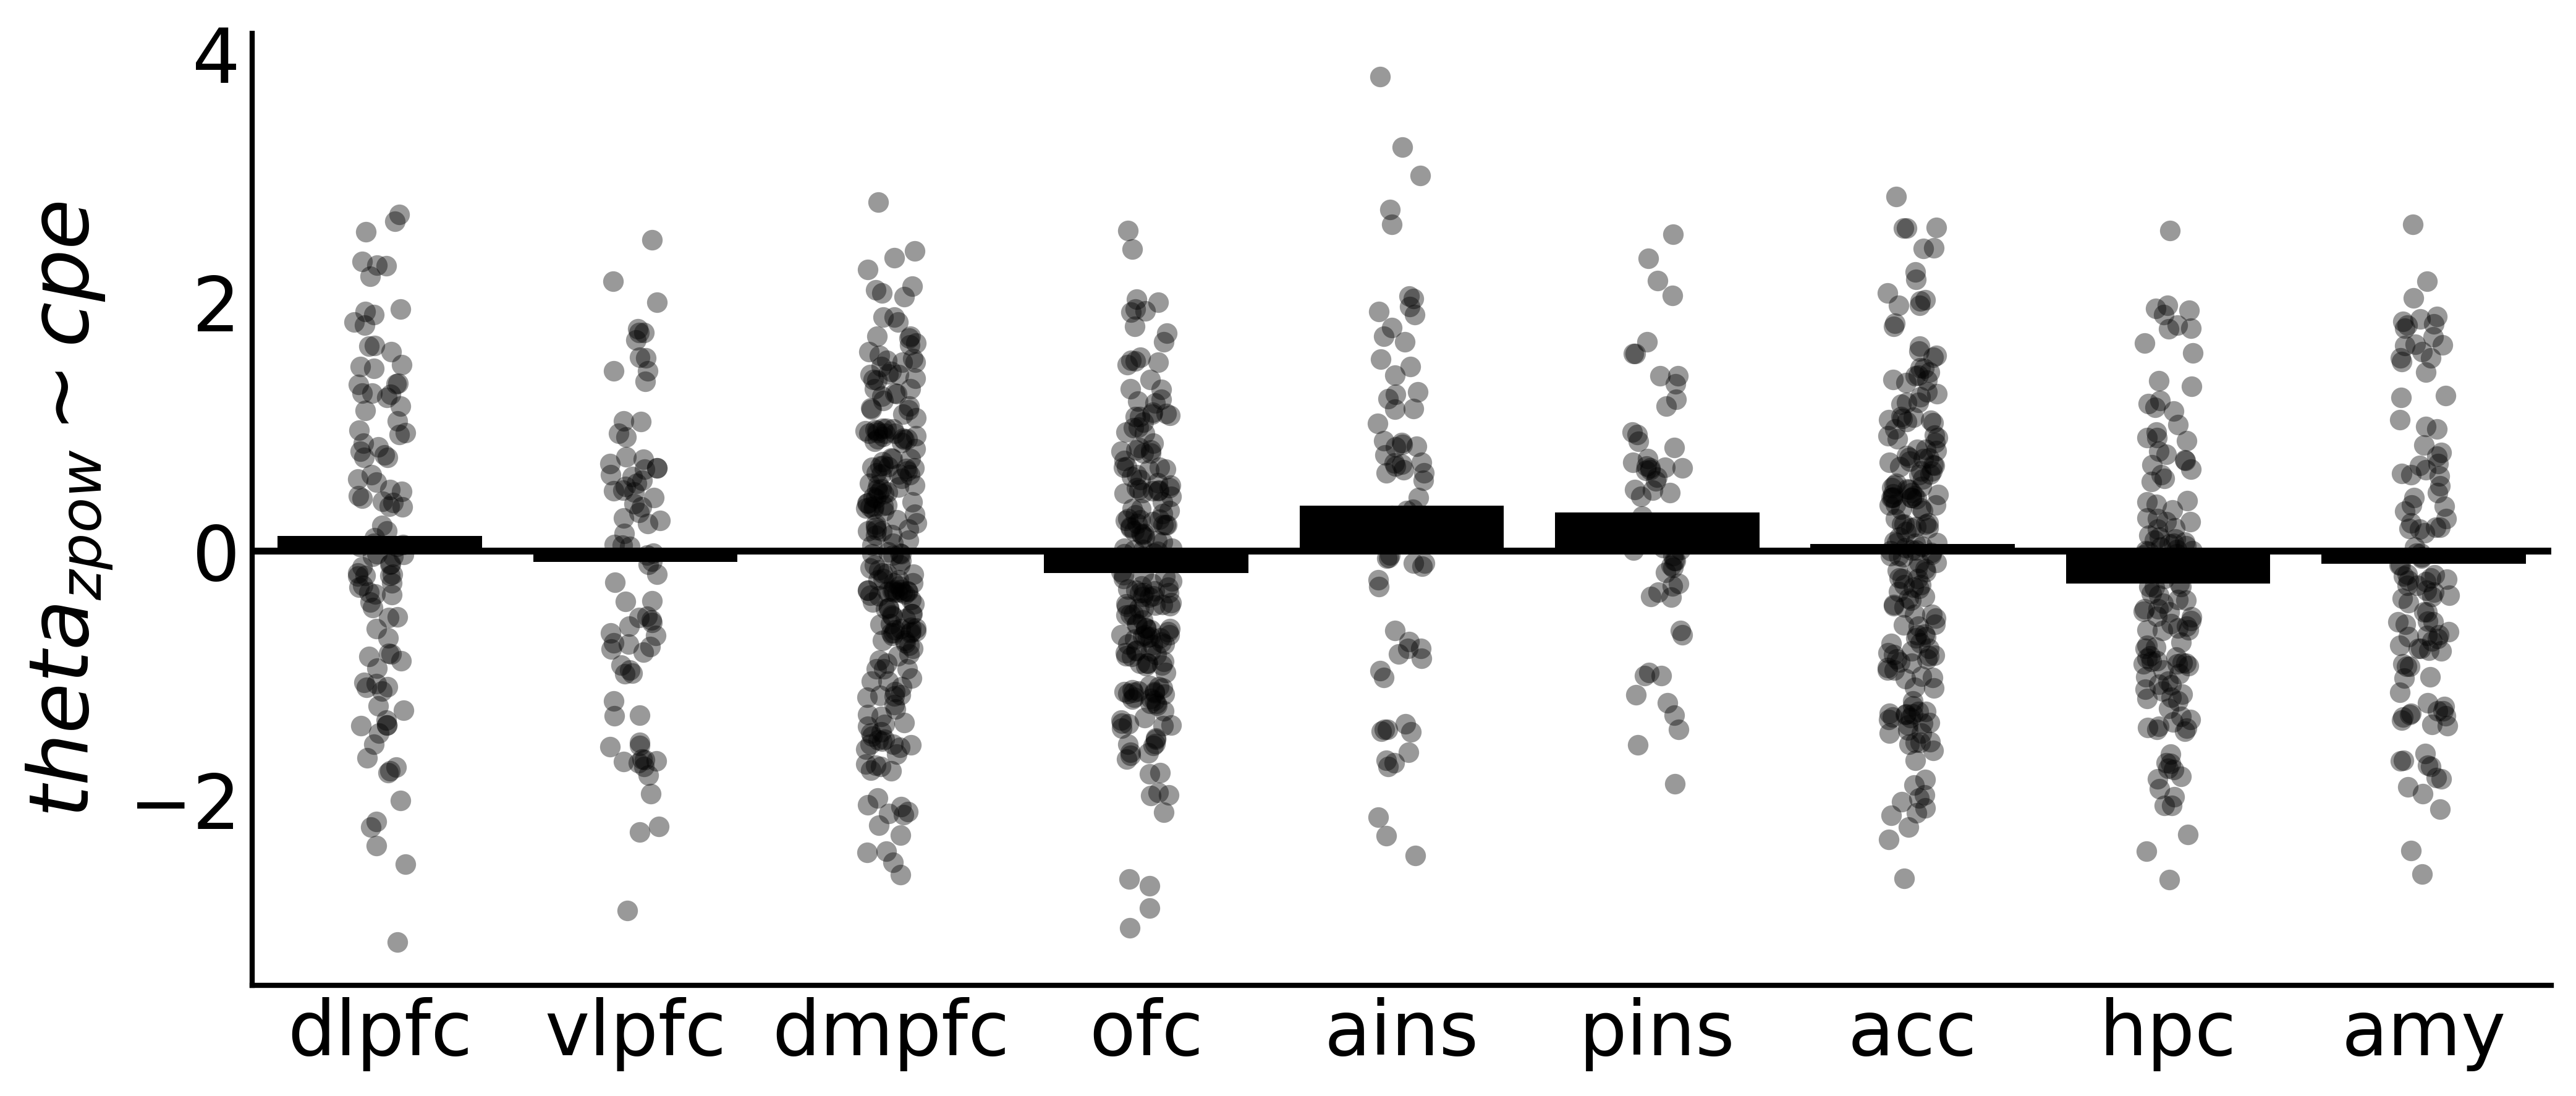

In [23]:

ylabel = fr'${band}_{{zpow}} \sim cpe$'
fig_id = f'{band}_single_elec_roi_barplot.pdf'

plot_roi_model_results(results,'roi','Z_Score_cpe',bar_order=bar_order,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=save_dir,fig_id=fig_id,dpi=400)





In [24]:
results.to_csv(f'{fig_save_dir}{band}_single_elec_perm_results.csv')


In [25]:
results.groupby('roi').agg('mean',numeric_only=True)['Z_Score_cpe'][bar_order]



roi
dlpfc    0.119657
vlpfc   -0.087960
dmpfc    0.015103
ofc     -0.176505
ains     0.364807
pins     0.307386
acc      0.054050
hpc     -0.264163
amy     -0.101713
Name: Z_Score_cpe, dtype: float64

In [26]:
single_elec_res = results.copy()[results.roi.isin(bar_order)]
single_elec_res



,unique_elec_id,subj_id,roi,bdi,Original_Estimate_Intercept,Original_Estimate_GambleChoice[T.safe],Original_Estimate_TotalProfit,Original_Estimate_cpe,Permuted_Mean_Intercept,Permuted_Mean_GambleChoice[T.safe],...,Permuted_Std_TotalProfit,Permuted_Std_cpe,Z_Score_Intercept,Z_Score_GambleChoice[T.safe],Z_Score_TotalProfit,Z_Score_cpe,P_Value_Intercept,P_Value_GambleChoice[T.safe],P_Value_TotalProfit,P_Value_cpe
0,MS002_lacas1-lacas2,MS002,acc,14,-0.002404,0.026304,0.096542,0.012772,0.017602,-0.002068,...,0.040528,0.042477,-0.661322,0.650696,2.384260,0.374232,0.508406,0.515242,0.017114,0.708232
1,MS002_lacas2-lacas3,MS002,acc,14,-0.029607,0.060478,0.049650,0.024515,0.012761,-0.000439,...,0.036068,0.034521,-1.547805,1.543317,1.417362,0.677992,0.121669,0.122754,0.156377,0.497776
2,MS002_lacas3-lacas4,MS002,acc,14,-0.027775,0.069989,-0.009460,-0.003664,0.020817,-0.000078,...,0.039862,0.039581,-1.575619,1.575941,-0.269481,-0.093993,0.115114,0.115039,0.787560,0.925114
3,MS002_lacas4-lacas5,MS002,acc,14,-0.001754,0.016347,0.003259,0.050621,0.009167,0.000285,...,0.042512,0.041789,-0.346391,0.353432,0.088235,1.238940,0.729049,0.723764,0.929690,0.215368
4,MS002_lacas5-lacas6,MS002,acc,14,0.017712,0.035032,0.011225,-0.018583,0.039760,0.003447,...,0.040574,0.041857,-0.708490,0.704293,0.280086,-0.449020,0.478641,0.481250,0.779411,0.653417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183,DA039_rpins1-rpins2,DA039,pins,22,0.016774,0.049682,-0.105989,0.040920,0.039079,0.000072,...,0.056084,0.056632,-0.968088,0.859422,-1.903590,0.671901,0.333001,0.390108,0.056964,0.501647
1184,DA039_rpins2-rpins3,DA039,pins,22,-0.002754,0.069187,-0.086819,-0.002043,0.025570,0.001898,...,0.050595,0.048851,-1.336519,1.265944,-1.679047,-0.171100,0.181380,0.205533,0.093143,0.864145
1185,DA039_rpins3-rpins4,DA039,pins,22,0.013212,-0.021304,-0.032891,-0.011266,0.004394,0.001929,...,0.050071,0.049375,0.405411,-0.426147,-0.637962,-0.260137,0.685175,0.670001,0.523499,0.794758
1186,DA039_rsgcc6-rsgcc7,DA039,vlpfc,22,-0.046201,0.040250,-0.066191,-0.031507,-0.029001,-0.000950,...,0.044887,0.043480,-0.944402,0.905718,-1.429033,-0.769852,0.344964,0.365085,0.152995,0.441388


In [27]:

single_rho_data = []
single_sig_rho = []

# BDI CORRELATIONS
for roi in single_elec_res.roi.unique().tolist():
    roi_temp_data = single_elec_res[single_elec_res.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.Z_Score_cpe)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
#     fe_results['rho'][fe_results.roi==roi]   = rho
#     fe_results['rho_p'][fe_results.roi==roi] = rho_p
    
    single_rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':np.round(rho_p,4)},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        single_sig_rho.append((roi,rho,rho_p))
#     print(f'{roi} pearsonr',rho,rho_p)

single_rho_data = pd.concat(single_rho_data).reset_index(drop=True)



In [29]:
agg_single_results = single_elec_res.groupby('roi').agg('mean',numeric_only=True)[['Z_Score_cpe']].copy()

agg_single_results


,Z_Score_cpe
roi,
acc,0.054050
ains,0.364807
amy,-0.101713
dlpfc,0.119657
dmpfc,0.015103
hpc,-0.264163
ofc,-0.176505
pins,0.307386
vlpfc,-0.087960


In [30]:
single_rho_data = single_rho_data.set_index('roi')
single_rho_data['Z_Score_cpe'] = agg_single_results.Z_Score_cpe
single_rho_data[['Z_Score_cpe','rho','rho_p']]



,Z_Score_cpe,rho,rho_p
roi,,,
acc,0.054050,0.003878,0.9573
dmpfc,0.015103,0.196796,0.0030
amy,-0.101713,0.154804,0.1016
ains,0.364807,-0.097443,0.4189
vlpfc,-0.087960,-0.107170,0.3379
hpc,-0.264163,0.048190,0.5789
ofc,-0.176505,0.001125,0.9873
pins,0.307386,-0.018977,0.8856
dlpfc,0.119657,0.268420,0.0052


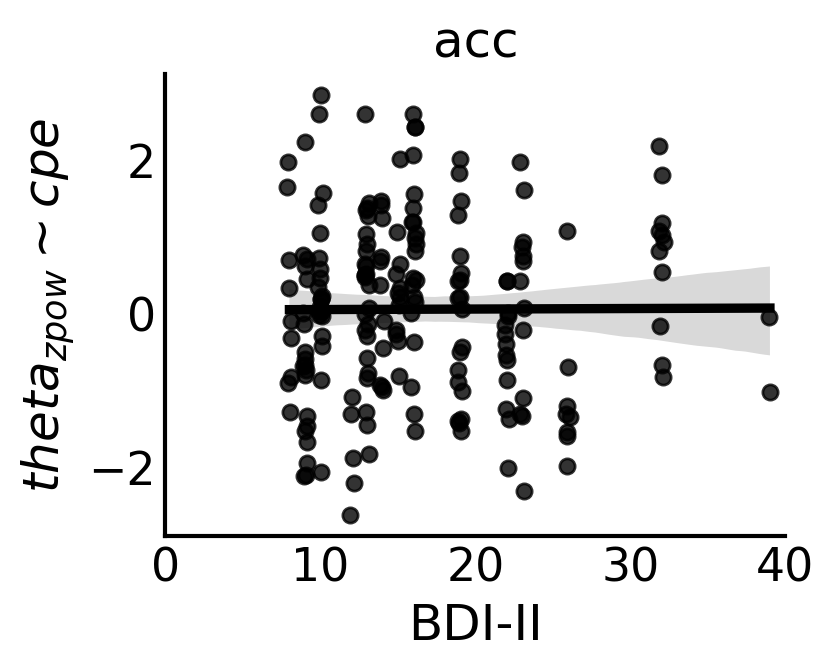

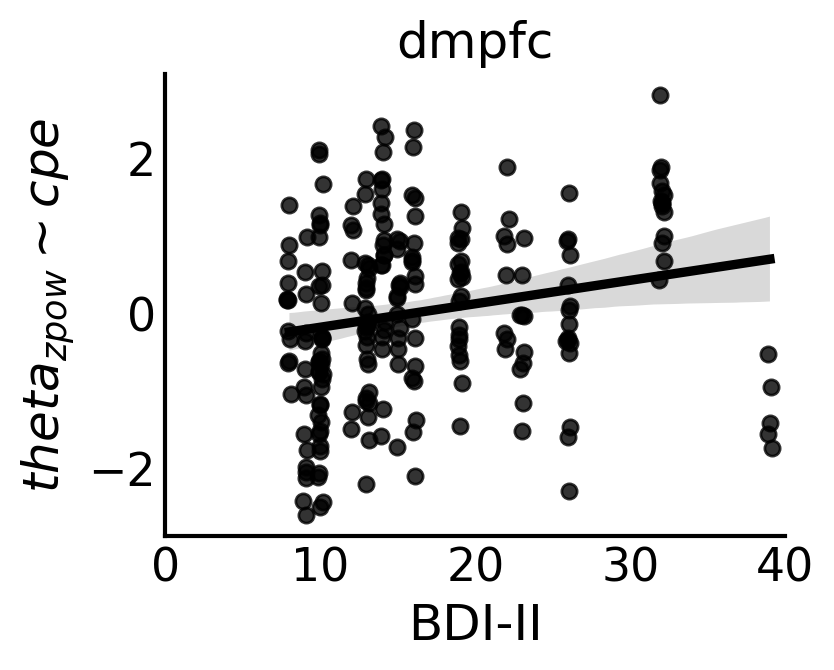

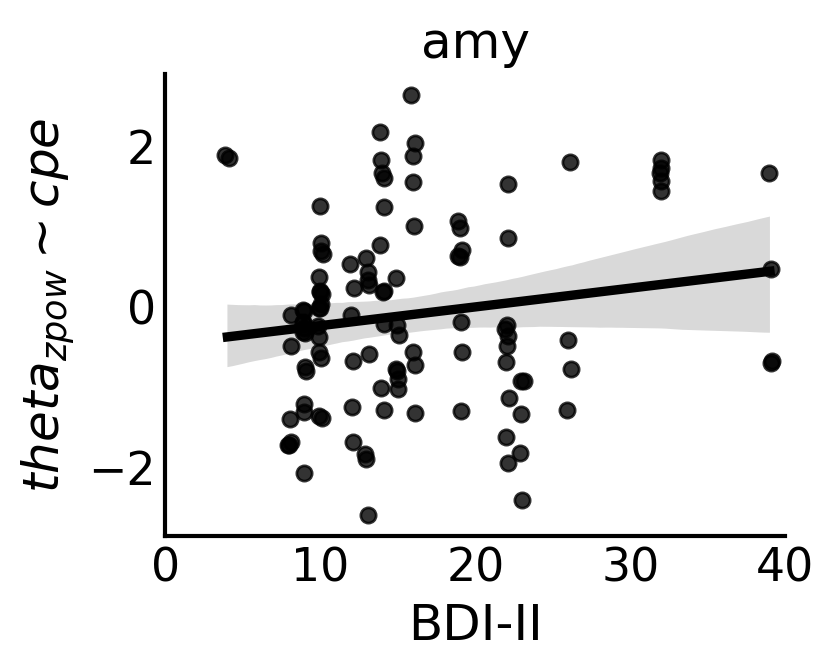

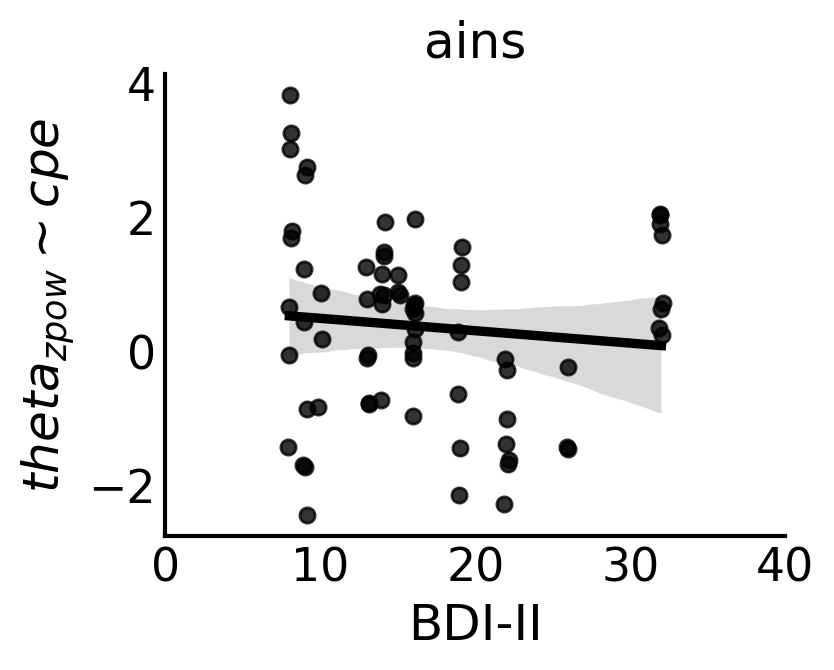

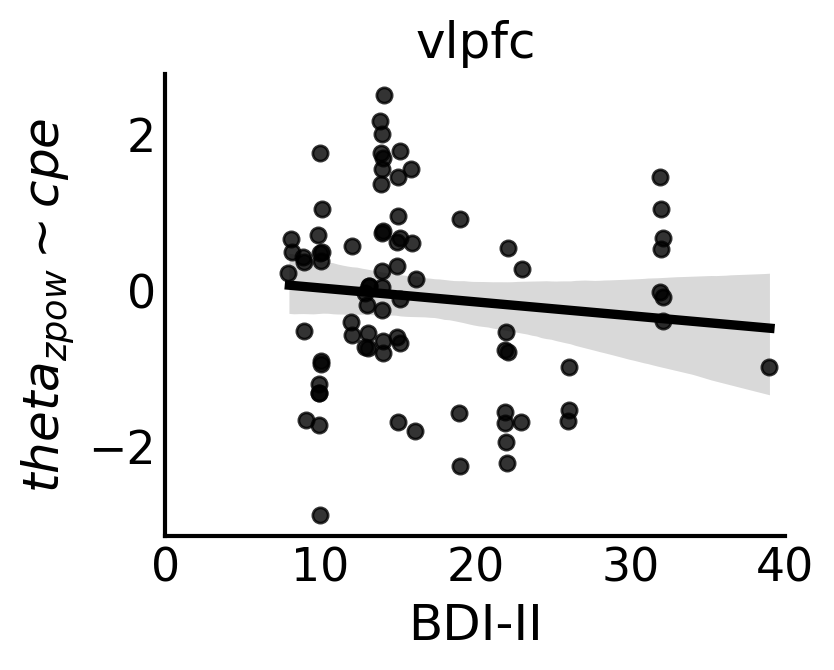

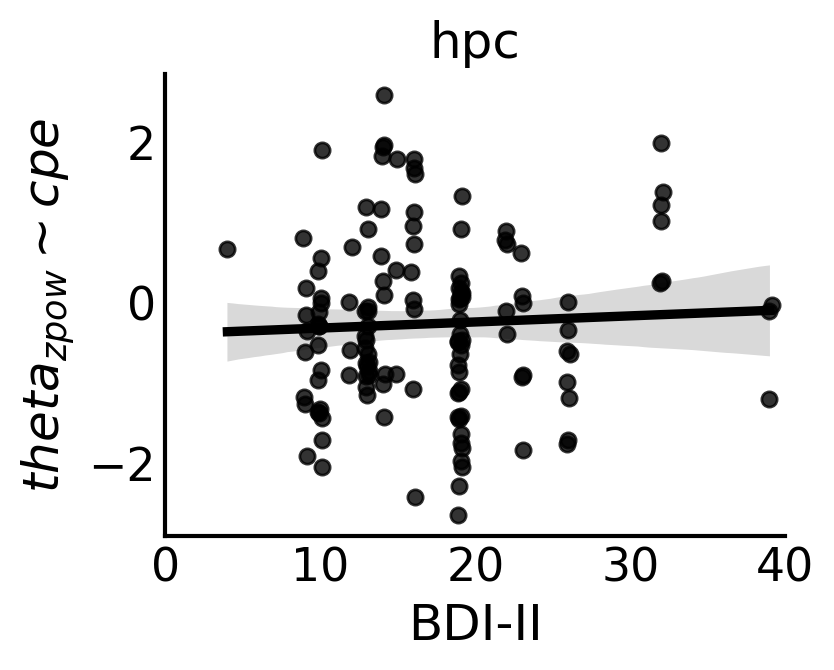

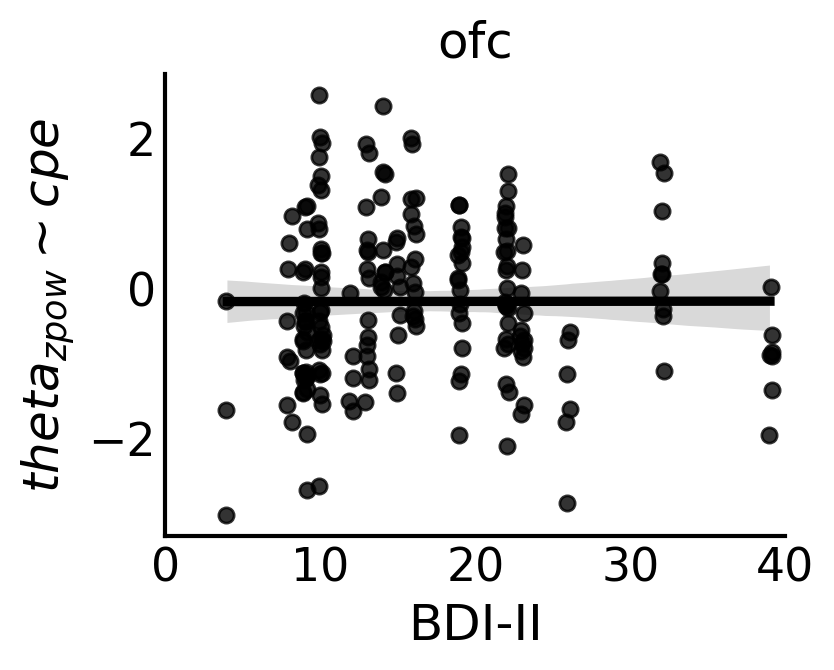

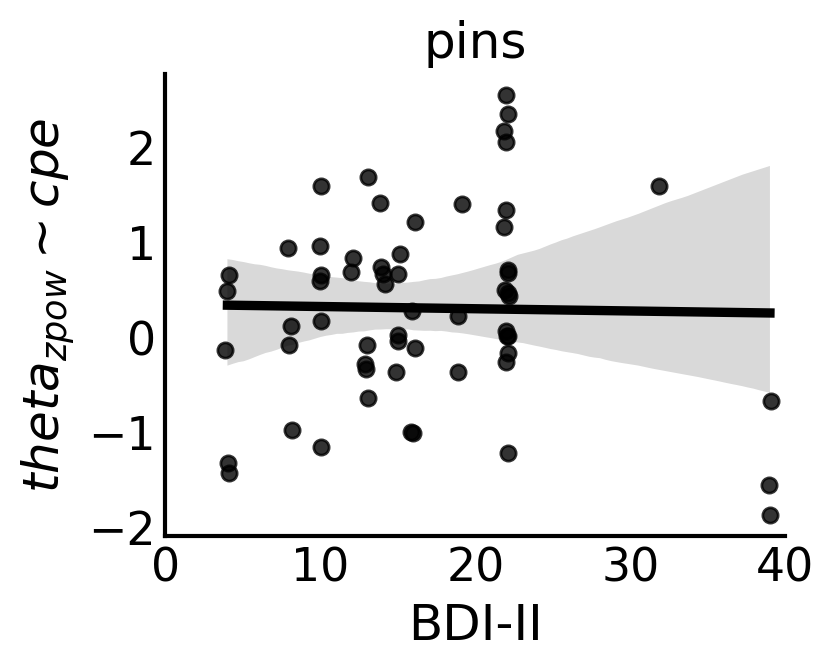

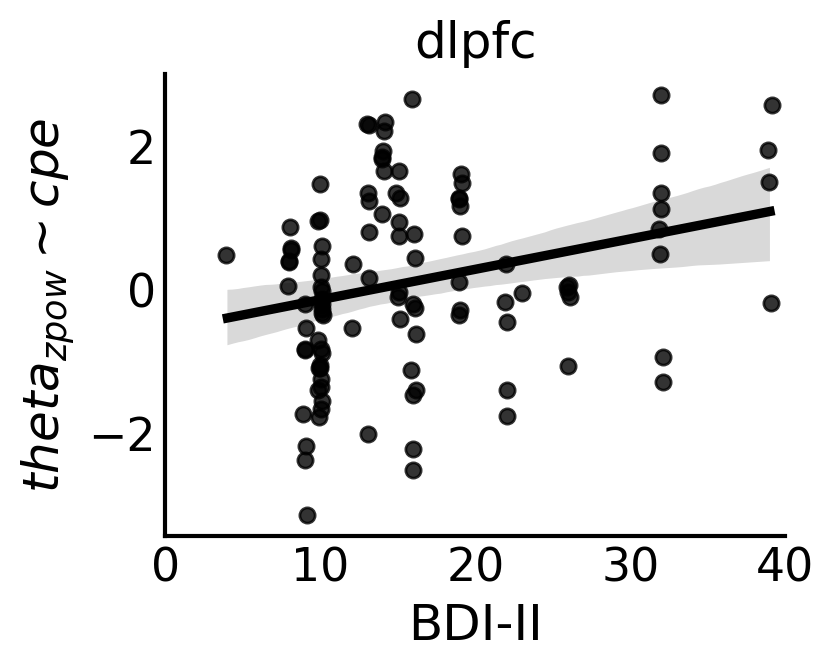

In [31]:
sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in single_elec_res.roi.unique().tolist():
    
    roi_temp_data = single_elec_res[single_elec_res.roi==roi]
    
    corr_fig_id = f'{band}_{roi}_bdi_cpe_coeff_scatter.pdf'
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=200)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_cpe',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.15,scatter_kws={'s':30}) #034975

    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim cpe$')


    plt.title(f'{roi}')
    sns.despine()
    
    
    plt.savefig(f'{fig_save_dir}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)


### Test BDI Correlations via robust regression

In [33]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in single_elec_res.roi.unique().tolist():
    roi_df = single_elec_res[single_elec_res.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_cpe.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())




acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 16 Sep 2024                                         
Time:                        00:08:19                                         
No. Iterations:                    17                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.9383      0.450     35.439     

# Mixed effects models

In [34]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
reg_vars     = ['GambleChoice','TotalProfit', 'cpe']
rand_vars    = ['GambleChoice','TotalProfit', 'cpe']


In [35]:
roi_fit_dict = {f'{roi}':fit_mixed_model(theta_reg_df[theta_reg_df.roi==roi],
                                        reg_vars,rand_vars,outcome_var,rand_eff_var) 
                for roi in theta_reg_df.roi.unique().tolist()}

roi_fit_results = []

for roi in list(roi_fit_dict.keys()):
    roi_fit = mixed_eff_results_df(roi_fit_dict[roi],theta_reg_df[theta_reg_df.roi==roi])
    roi_fit_results.append(roi_fit)
    
roi_fit_results = pd.concat(roi_fit_results).reset_index(drop=True)


In [36]:
roi_fit_results['band'] = band
roi_fit_results.to_csv(f'{save_dir}{band}_roi_reg_results.csv')

# raw_roi_stats = {f'{roi}':ttest_1samp(roi_fit_results.decisionCPE[roi_fit_results.roi == roi].unique(),
#                  popmean=0) for roi in roi_fit_results.roi.unique().tolist()}
# raw_roi_stats

In [37]:
# roi_fit_results

fe_params_results = {f'{roi}':roi_fit_dict[roi].fe_params for roi in list(roi_fit_dict.keys())}
fe_results = []
for fe_res in fe_params_results:
    fe_results.append(pd.DataFrame({**dict(fe_params_results[fe_res]),**{'roi':fe_res}},index=[0]))
    
fe_results = pd.concat(fe_results).reset_index(drop=True)
fe_results['cpe_pval'] = [np.round(roi_fit_dict[roi].pvalues['cpe'],4) for roi in fe_results.roi.tolist()]
# fe_results['bdi_pval'] = [np.round(roi_fit_dict[roi].pvalues['bdi'],4) for roi in fe_results.roi.tolist()]
# fe_results['cpe_bdi_pval'] = [np.round(roi_fit_dict[roi].pvalues['bdi:decisionCPE'],4) for roi in fe_results.roi.tolist()]

fe_results


,Intercept,GambleChoice[T.safe],GambleChoice[T.skip],TotalProfit,cpe,roi,cpe_pval
0,0.000653,0.006152,0.128864,0.010418,0.002392,acc,0.5122
1,-0.009649,0.006583,0.047591,0.000119,0.001577,dmpfc,0.6514
2,-0.017146,-0.002705,0.069141,0.011325,-0.002248,amy,0.6313
3,-0.012229,0.040943,-0.320878,-0.024432,0.016207,ains,0.0269
4,-0.017376,-0.000713,-0.089997,0.003397,-0.002756,vlpfc,0.6118
5,-0.046529,0.010815,0.027230,-0.004530,-0.009003,hpc,0.0094
6,-0.022739,-0.001476,0.180120,0.001329,-0.007116,ofc,0.0252
7,-0.012601,0.020333,-0.120515,0.012014,0.010064,pins,0.0670
8,-0.006861,-0.000281,-0.106974,-0.004730,0.007859,dlpfc,0.1748


In [38]:
fe_results.set_index('roi')

,Intercept,GambleChoice[T.safe],GambleChoice[T.skip],TotalProfit,cpe,cpe_pval
roi,,,,,,
acc,0.000653,0.006152,0.128864,0.010418,0.002392,0.5122
dmpfc,-0.009649,0.006583,0.047591,0.000119,0.001577,0.6514
amy,-0.017146,-0.002705,0.069141,0.011325,-0.002248,0.6313
ains,-0.012229,0.040943,-0.320878,-0.024432,0.016207,0.0269
vlpfc,-0.017376,-0.000713,-0.089997,0.003397,-0.002756,0.6118
hpc,-0.046529,0.010815,0.027230,-0.004530,-0.009003,0.0094
ofc,-0.022739,-0.001476,0.180120,0.001329,-0.007116,0.0252
pins,-0.012601,0.020333,-0.120515,0.012014,0.010064,0.0670
dlpfc,-0.006861,-0.000281,-0.106974,-0.004730,0.007859,0.1748


In [39]:
bonferr_alpha = 0.05/len(fe_results)
# bonferr_alpha = 0.01

bonferr_alpha

0.005555555555555556

In [40]:
sig_cpe_rois = fe_results.roi[fe_results.cpe_pval <= bonferr_alpha].tolist()
sig_cpe_rois

[]

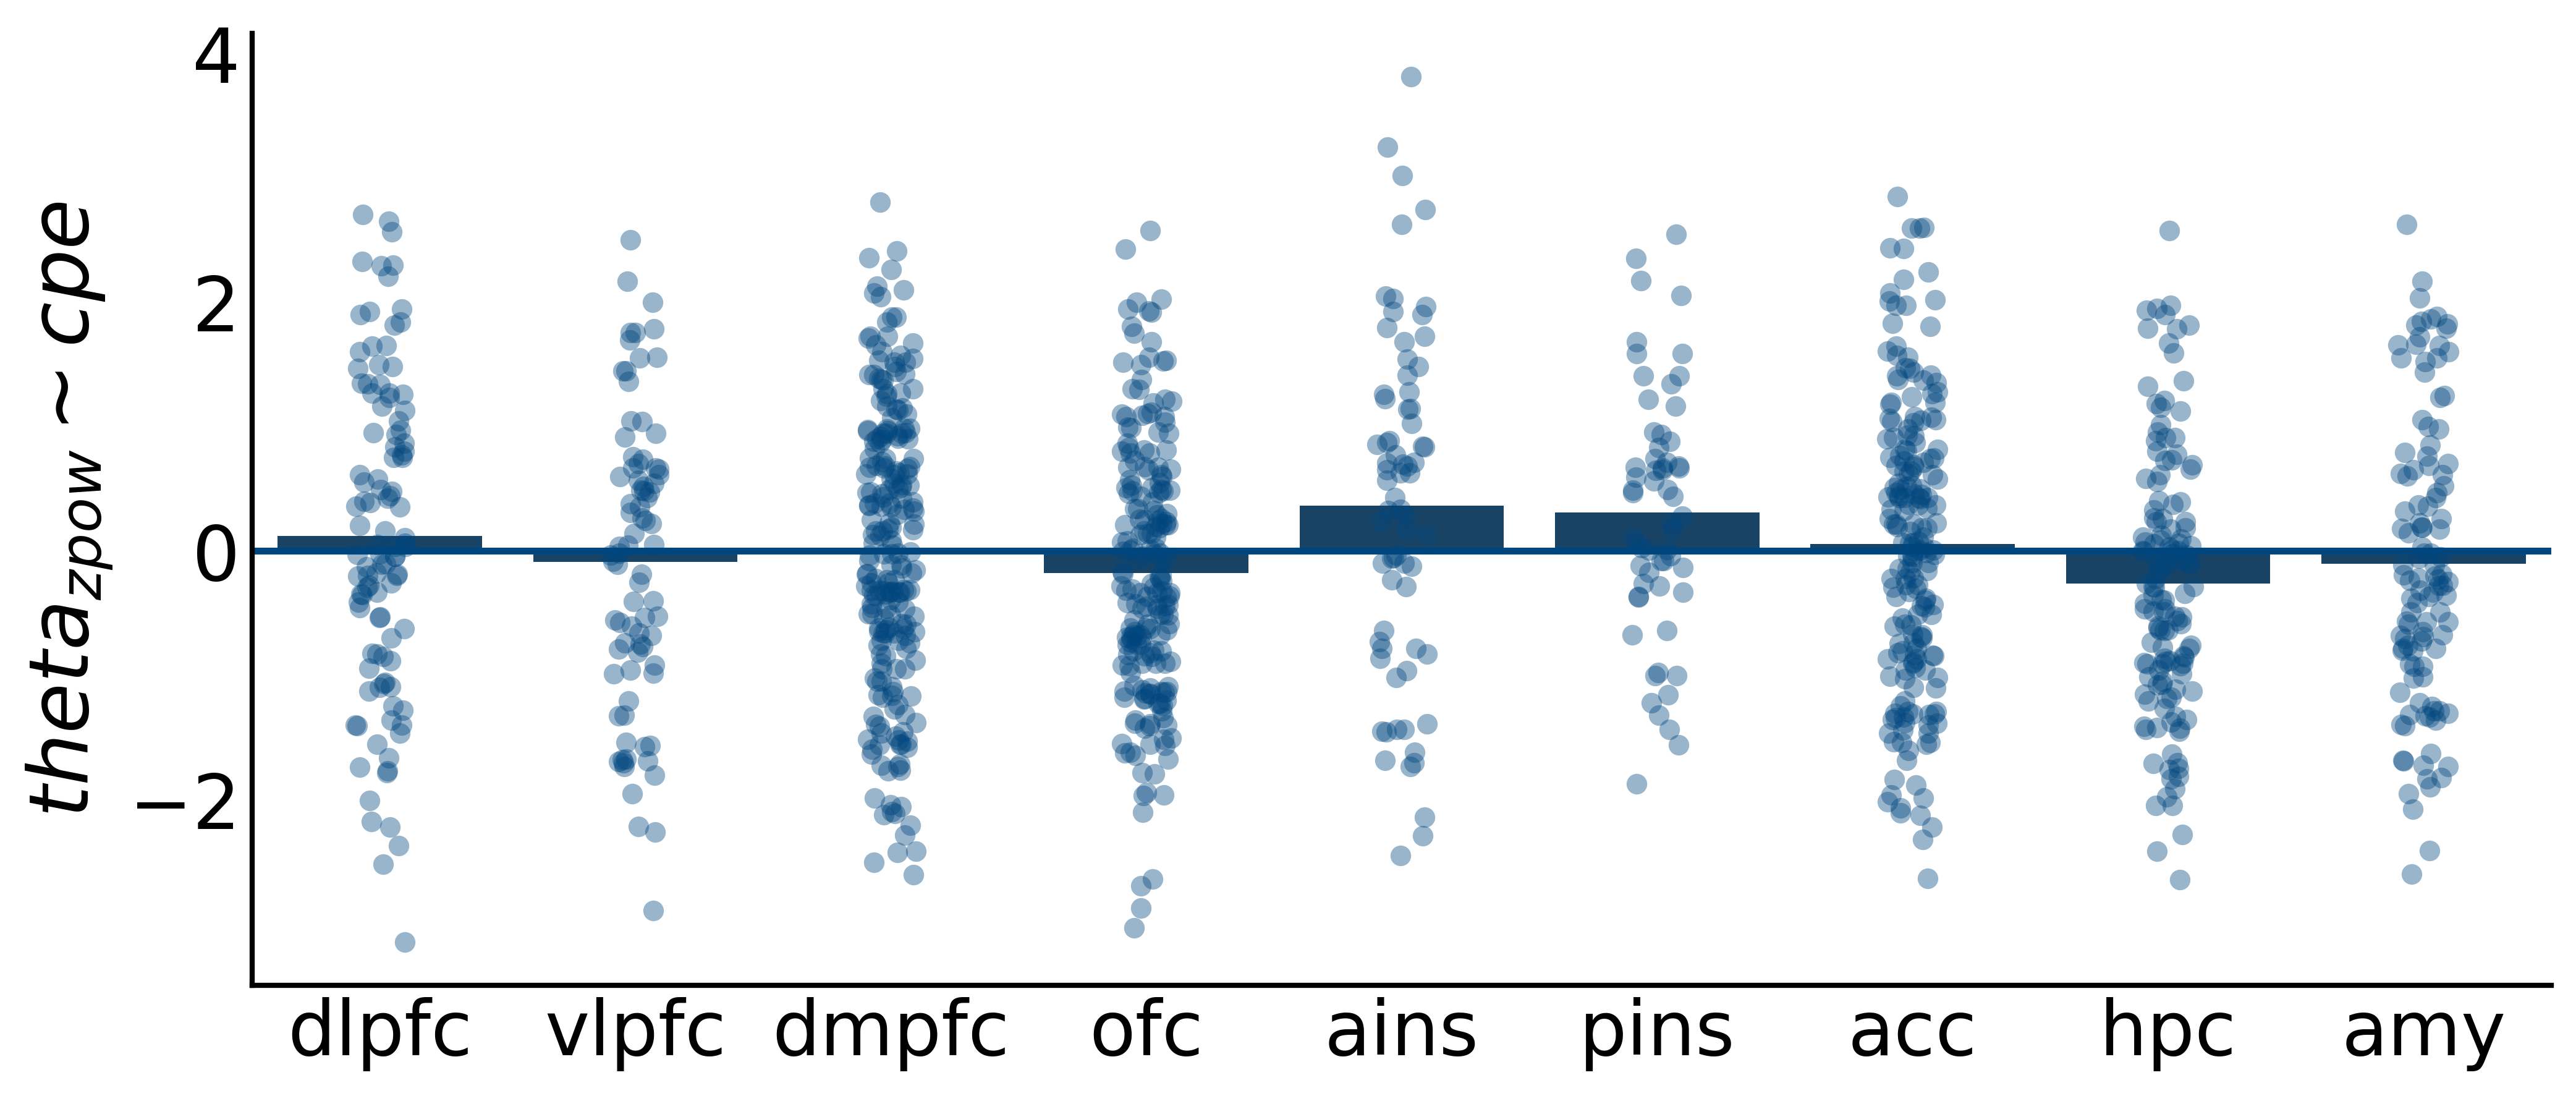

In [43]:

ylabel = fr'${band}_{{zpow}} \sim cpe$'
fig_id = f'{band}_mlm_roi_barplot.pdf'

plot_roi_model_results(results,'roi','Z_Score_cpe',bar_order=bar_order,figsize=(12,5),color='#00467e',
                       ylabel=ylabel,save_fig=True,save_dir=save_dir,fig_id=fig_id,dpi=400)



# BDI Correlation

In [44]:
# CHECK BDI CORRELATION

rho_data = []
sig_rho = []

# BDI CORRELATIONS
for roi in roi_fit_results.roi.unique().tolist():
    roi_temp_data = roi_fit_results[roi_fit_results.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.cpe)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
    rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':rho_p},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        sig_rho.append((roi,rho,rho_p))
    print(f'{roi} pearsonr',rho,rho_p)
rho_data = pd.concat(rho_data).reset_index(drop=True)


acc pearsonr 0.08528614637686302 0.2382842331566307
dmpfc pearsonr 0.3106177189617491 2.020442904452344e-06
amy pearsonr 0.166265192093504 0.07840031336387022
ains pearsonr -0.19933389341077284 0.09559898194077739
vlpfc pearsonr -0.11983818594302323 0.2835441954896925
hpc pearsonr 0.20258489382483888 0.018451835561222686
ofc pearsonr 0.06760607493597513 0.3390751681117162
pins pearsonr 0.2607602775471192 0.044187054090183586
dlpfc pearsonr 0.3287574690937767 0.0005454649428070229


In [45]:
sig_rho

[('dmpfc', 0.3106177189617491, 2.020442904452344e-06),
 ('hpc', 0.20258489382483888, 0.018451835561222686),
 ('pins', 0.2607602775471192, 0.044187054090183586),
 ('dlpfc', 0.3287574690937767, 0.0005454649428070229)]

In [46]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in roi_fit_results.roi.unique().tolist():
    roi_df = roi_fit_results[roi_fit_results.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.cpe.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())




acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 16 Sep 2024                                         
Time:                        00:13:44                                         
No. Iterations:                    13                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.7952      0.458     34.490     

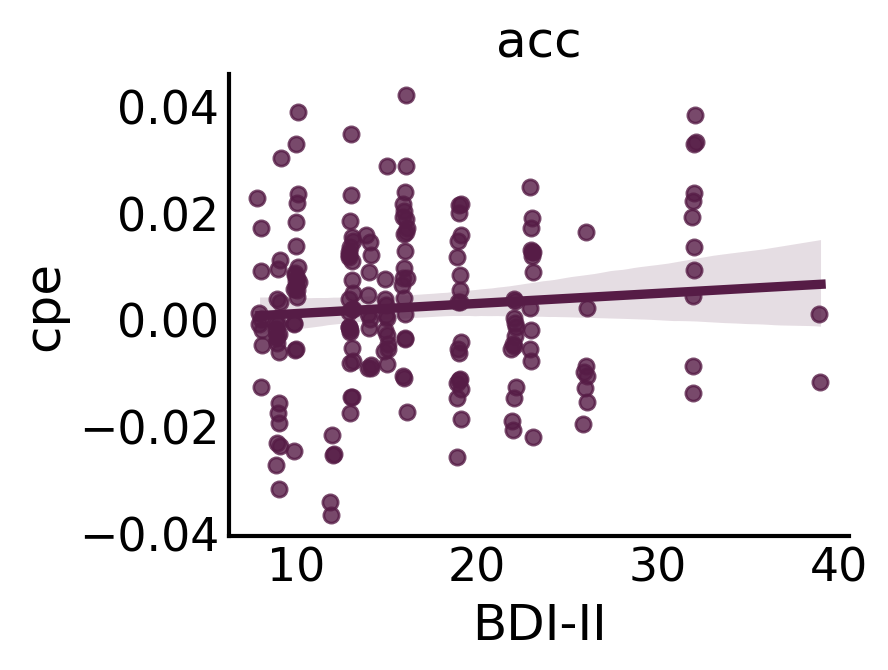

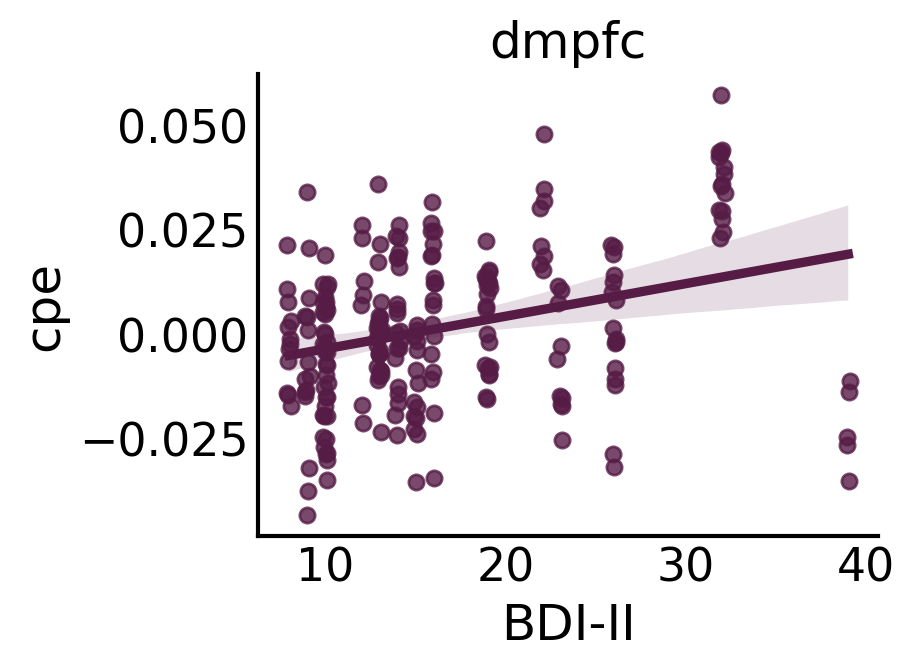

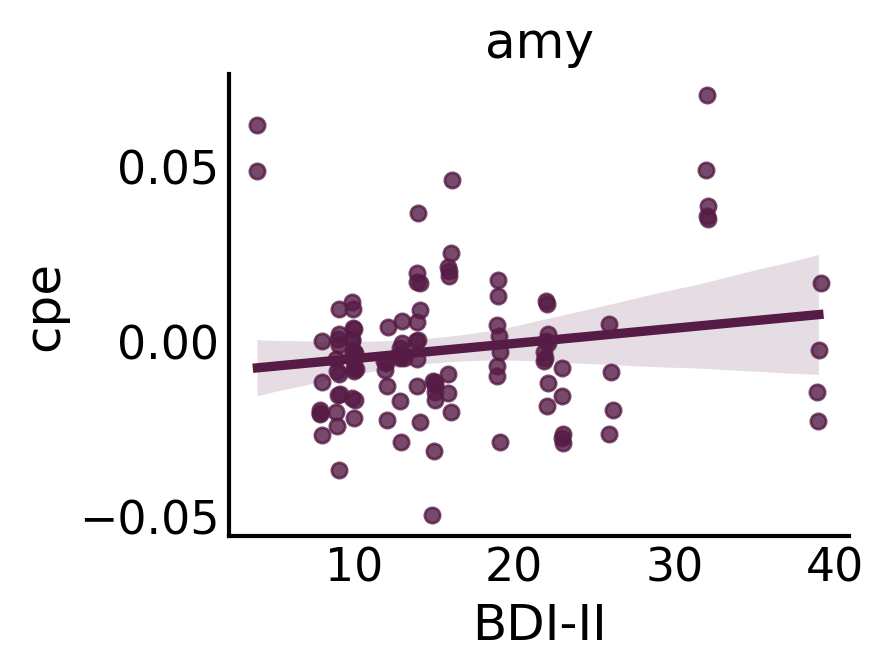

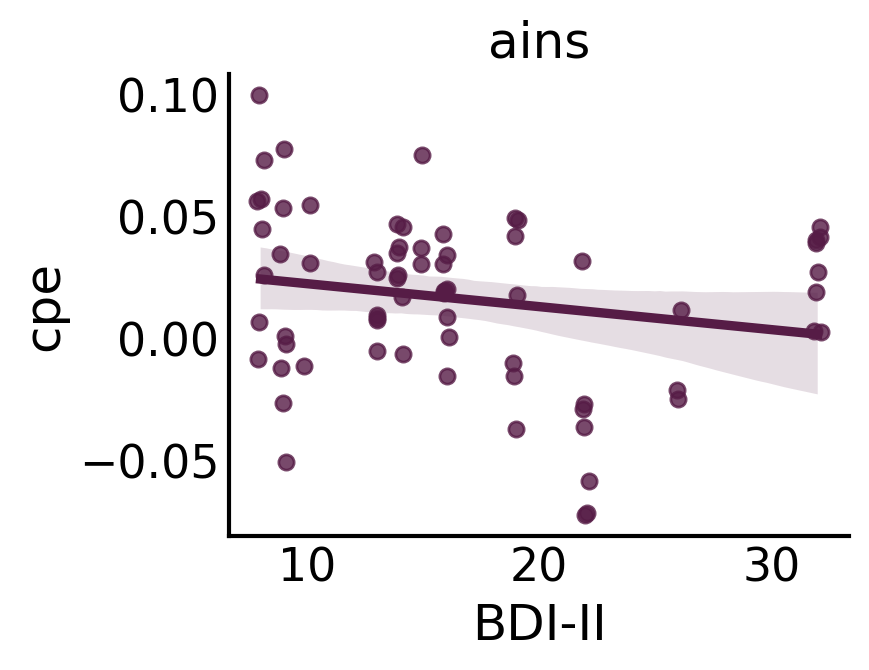

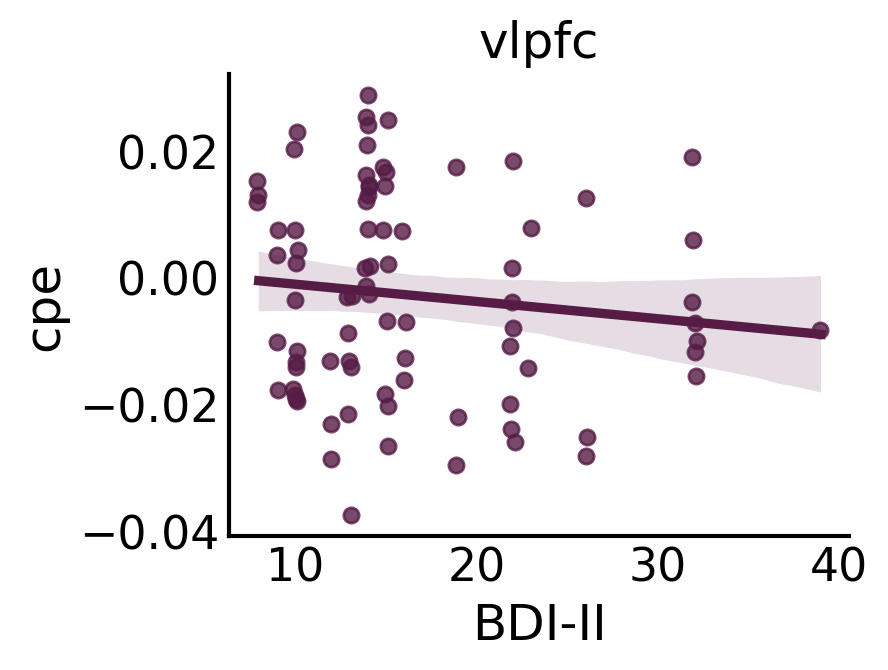

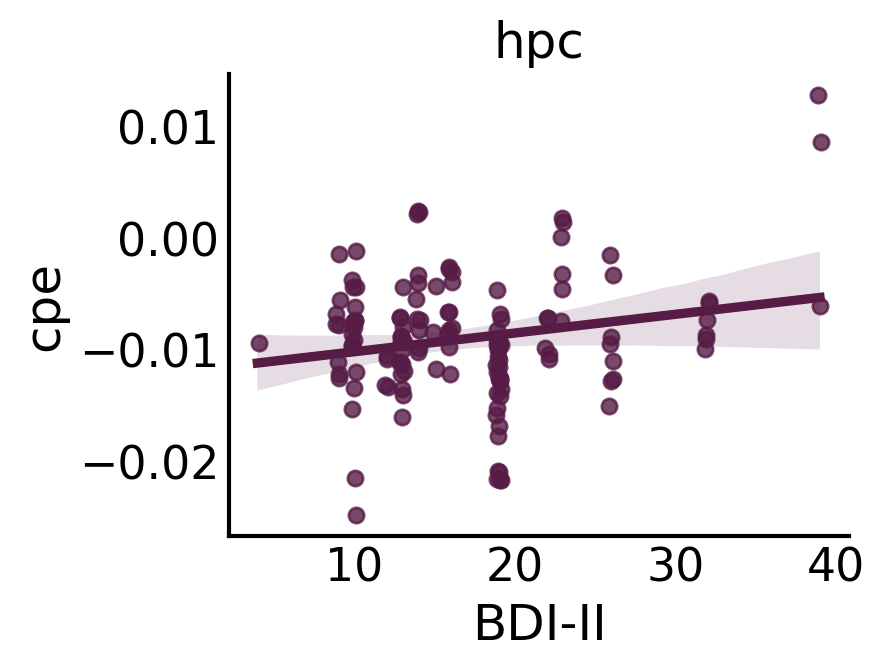

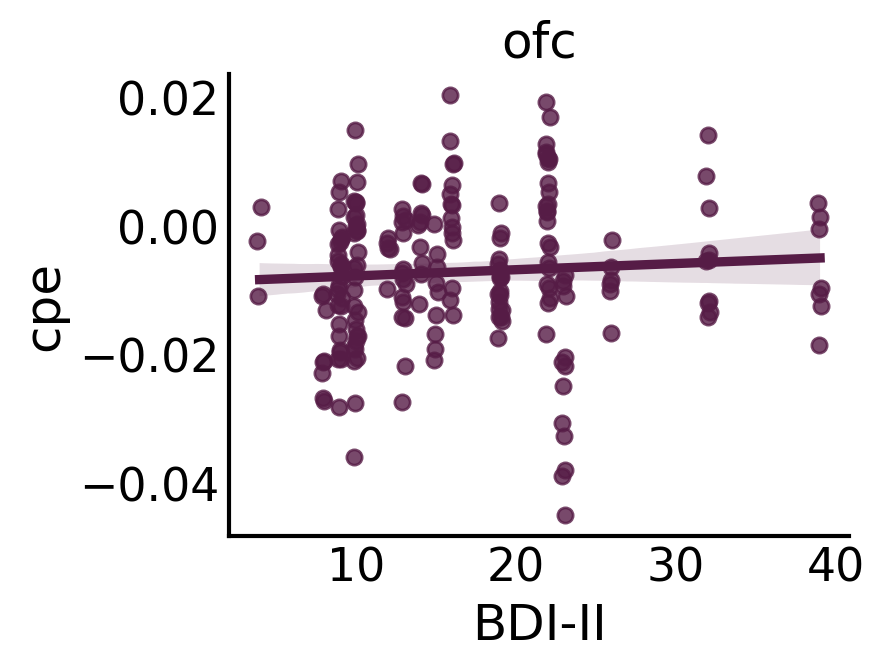

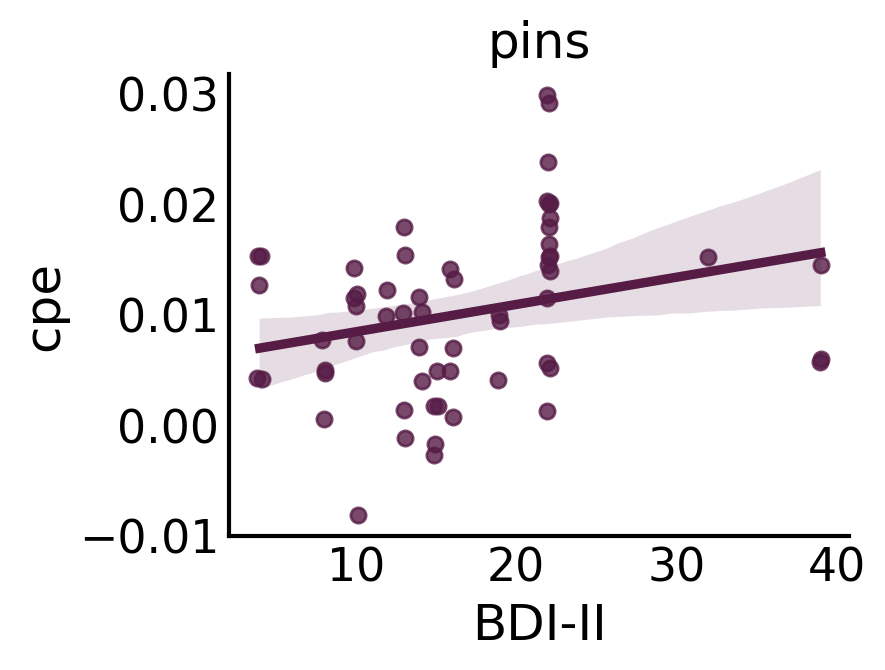

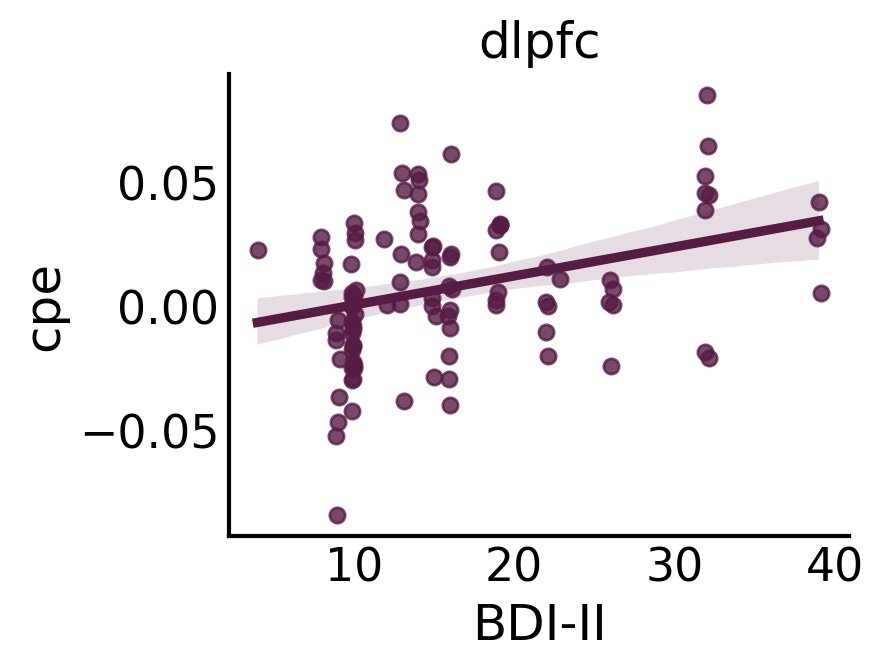

In [47]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in roi_fit_results.roi.unique().tolist():
    
    roi_temp_data = roi_fit_results[roi_fit_results.roi==roi]

#     rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
#     rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=200)

    sns.regplot(data=roi_temp_data,x='bdi',y='cpe',scatter=True,ci=95,
                fit_reg=True,color = '#561C46',x_jitter = 0.15,scatter_kws={'s':30}) #034975
    
#     sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
#                     y='decisionCPE',color = '#00467e',edgecolor=None,alpha=0.8)
    
#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.xlabel('BDI-II')
#     plt.xlim([0,40])
    
    plt.tick_params(length=0) 
#     plt.ylabel('beta'+r'$beta_{{{zpow}}}$'+' cpe encoding')
#     plt.ylabel(fr'${band}_{{{zpow}}} \sim cpe$')

#     plt.text(np.max(roi_temp_data.bdi)-8,
#              np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').elec_bCPE),3)-0.003,
#              r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',color='k',fontsize=12)
#              color='#00467e',fontsize=16)
#     plt.text(0.8,0.8,r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',
#             verticalalignment='top', horizontalalignment='right',
#             color='k',fontsize=16)

    plt.title(f'{roi}')
    sns.despine()
#     plt.tight_layout()


    
#     sns.despine()
    
    plt.savefig(f'{fig_dir}/{band}_{roi}_{rho}_{rho_p}_roi_bdi-cpe-slope.pdf', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=300,
        facecolor='auto', edgecolor='auto',
        backend=None)
    

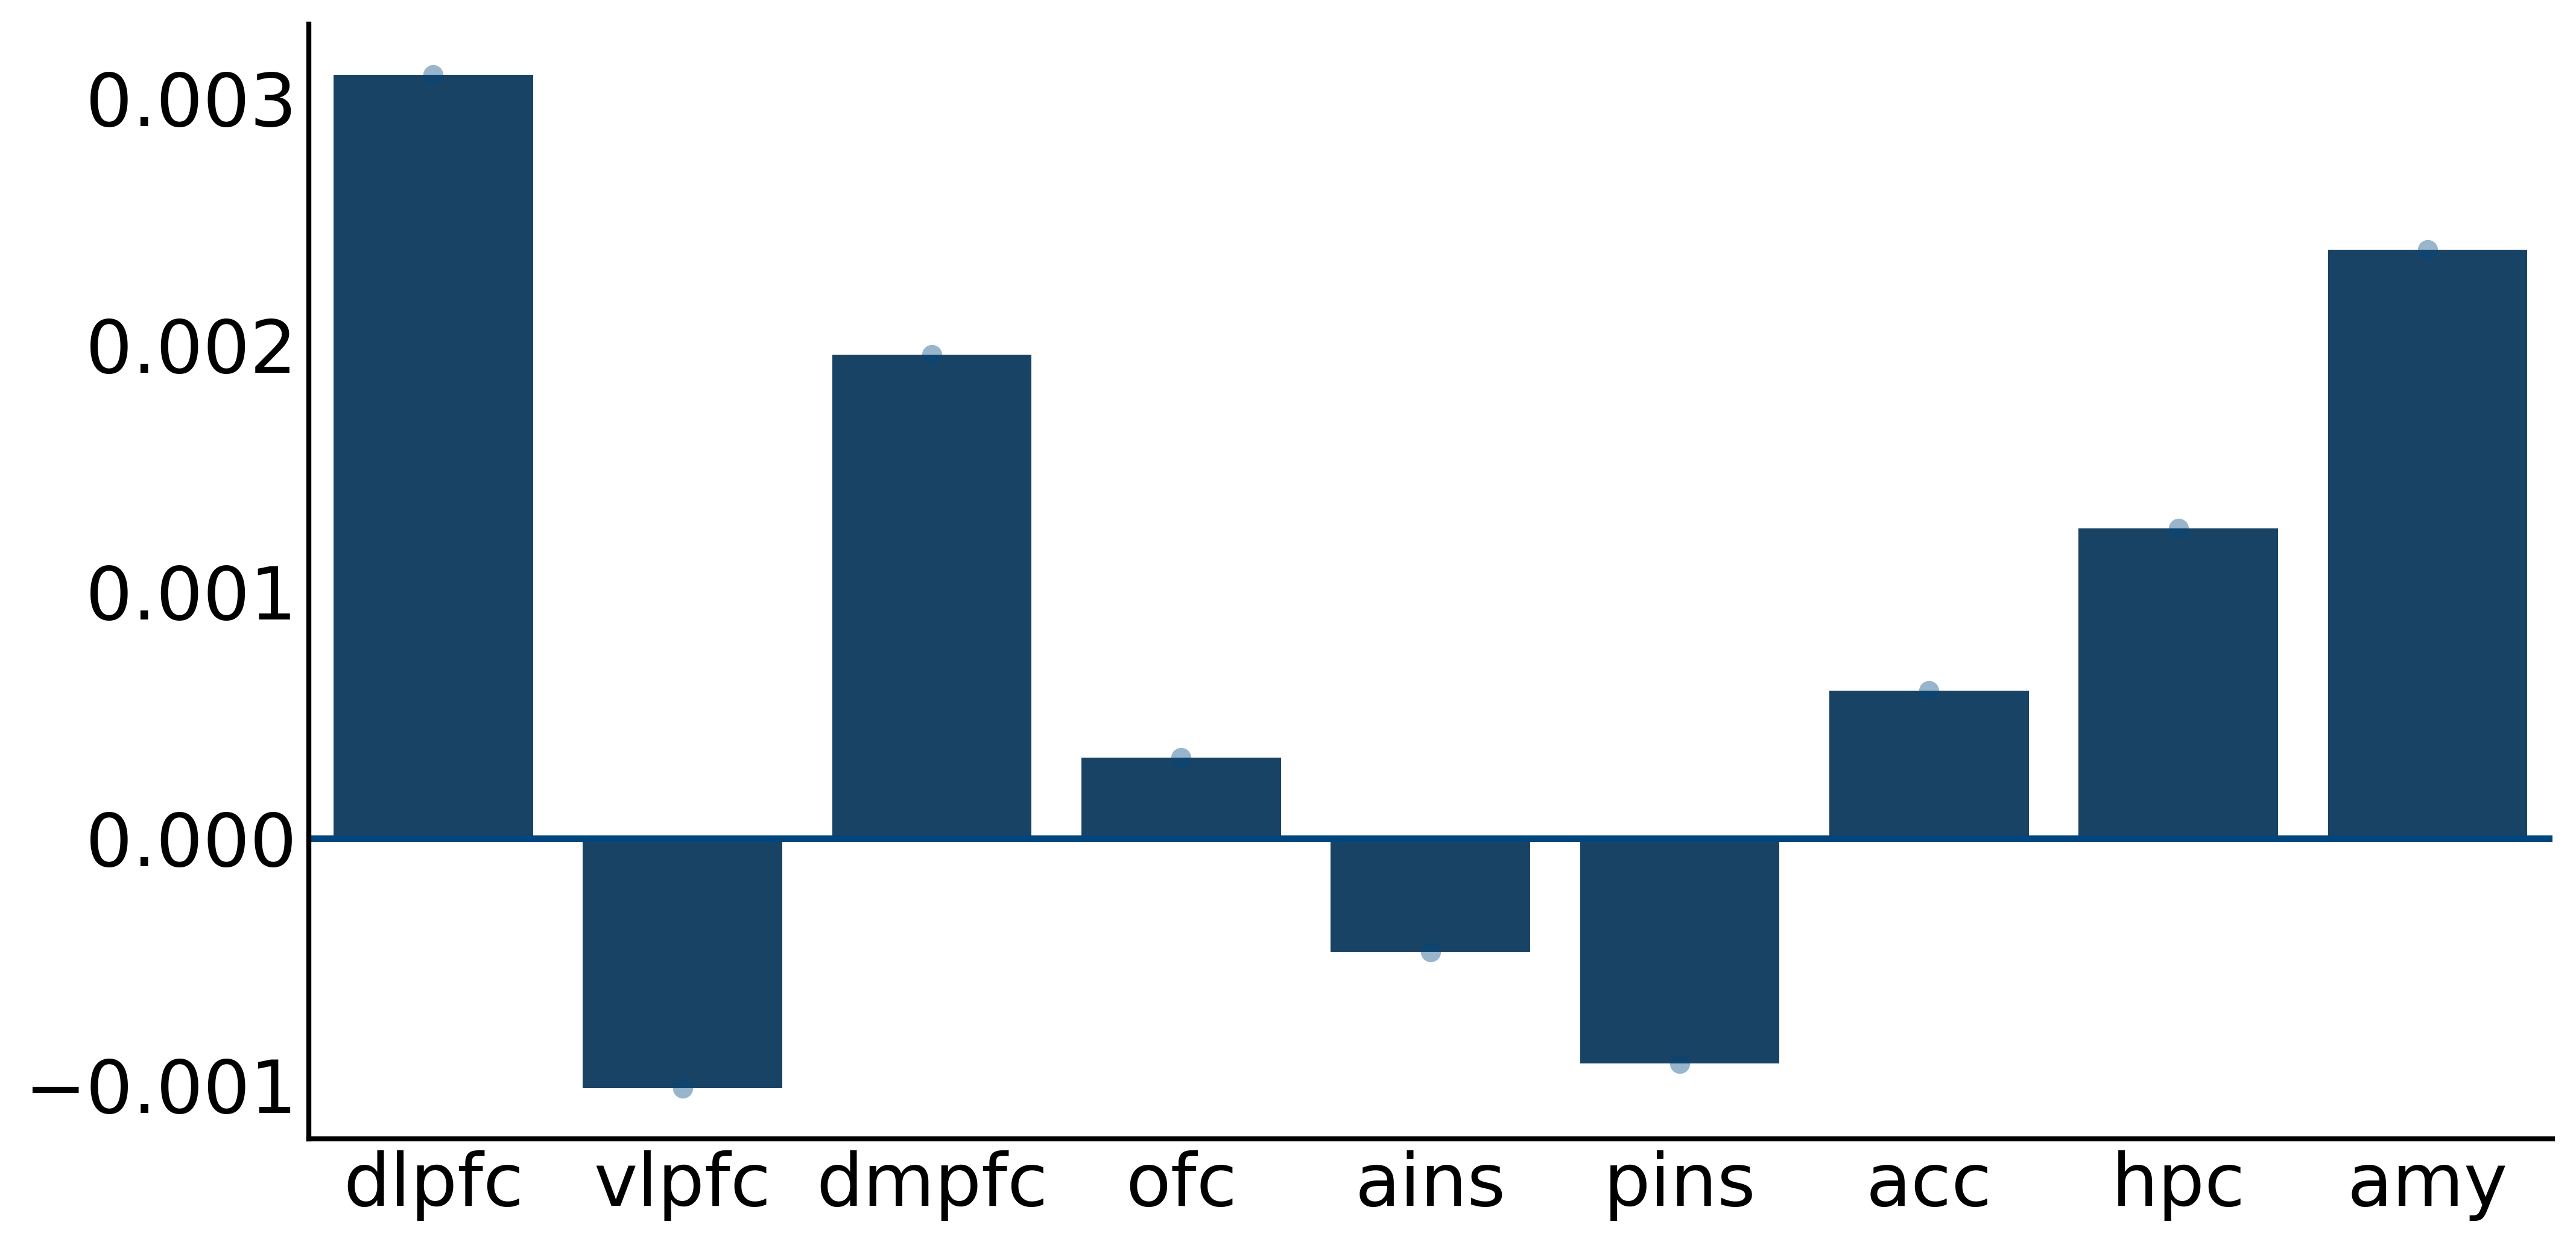

In [38]:
plot_roi_model_results(fe_results,'roi',"bdi:decisionCPE",bar_order=bar_order,figsize=(12,6),color='#00467e')
# add to slides 
